In [ ]:
# --- 1. 라이브러리 및 기본 경로 설정 ---
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
import os
import ast
import dask
import cv2
import json
from IPython.display import display
import functools
import operator

In [ ]:
# --- 2. 데이터 로딩 ---
# 전처리된 Parquet 파일이 저장된 경로를 지정합니다.
base_dir = Path(os.getcwd()).resolve().parent
preprocessed_path = base_dir / "preprocessed_data/TL_prepro"
data_path = base_dir / "assets"

print("전처리된 Parquet 파일 로딩 중...")
images_ddf = dd.read_parquet(preprocessed_path / "*/*_images.parquet")
annotations_ddf = dd.read_parquet(preprocessed_path / "*/*_annotations.parquet")

# 카테고리 정보 로드 (이전과 동일)
with (data_path / "categories.json").open("r", encoding="utf-8") as f:
    categories = json.load(f)
categories_df = pd.DataFrame(categories)
categories_df[['category_group', 'category_name']] = categories_df['name'].str.split('@', n=1, expand=True)
print("데이터 로딩 완료.")

전처리된 Parquet 파일 로딩 중...
데이터 로딩 완료.


In [ ]:
# --- 3. 특성 엔지니어링 (w, h, area, aspect_ratio 등 계산) ---

def calculate_features(bbox_list):
    # bbox 리스트가 유효한지 확인
    if len(bbox_list) == 4:
        x, y, w, h = bbox_list
        x2 = x + w
        y2 = y + h
        aspect_ratio = w / (h + 1e-6) # 0으로 나누기 방지
        center_x = (x + w) / 2
        center_y = (y + h) / 2
        return pd.Series([x, y, w, h, x2, y2, aspect_ratio, center_x, center_y], index=['x', 'y', 'w', 'h', 'x2', 'y2','aspect_ratio', 'center_x', 'center_y'])
    else:
        # 유효하지 않은 데이터는 NaN으로 채워진 Series 반환
        return pd.Series([None] * 9, index=['x', 'y', 'w', 'h', 'x2', 'y2', 'aspect_ratio', 'center_x', 'center_y'])

# .apply 결과가 여러 컬럼으로 확장될 것을 meta로 알려줌
new_cols_ddf = annotations_ddf['bbox'].apply(
    calculate_features,
    # meta 정보에 새로 생길 컬럼들의 이름과 데이터 타입을 명시
    meta={'x': 'f8', 'y': 'f8', 'w': 'f8', 'h': 'f8', 'x2': 'f8', 'y2': 'f8', 'aspect_ratio': 'f8', 'center_x': 'f8', 'center_y': 'f8'}
)

# 기존 데이터프레임과 새로운 컬럼들을 결합
annotations_ddf = dd.concat([annotations_ddf, new_cols_ddf], axis=1)

# 결과 확인
display(annotations_ddf.head())

,id,image_id,category_id,iscrowd,area,bbox,attributes.vendor,attributes.shipType,attributes.pidLabel,x,y,w,h,x2,y2,aspect_ratio,center_x,center_y
0,1,V01_04_006_001_1,1726,0,33897.39,"[5678.1, 6627.2, 166.9, 203.1]",V01,Semi-Rig,,5678.1,6627.2,166.9,203.1,5845.0,6830.3,0.821763,2922.50,3415.15
1,2,V01_04_006_001_1,1726,0,32317.07,"[5038.4, 6627.0, 163.3, 197.9]",V01,Semi-Rig,,5038.4,6627.0,163.3,197.9,5201.7,6824.9,0.825164,2600.85,3412.45
2,3,V01_04_006_001_1,1726,0,34283.34,"[4521.2, 6624.4, 163.8, 209.3]",V01,Semi-Rig,,4521.2,6624.4,163.8,209.3,4685.0,6833.7,0.782609,2342.50,3416.85
3,4,V01_04_006_001_1,1758,0,63575.42,"[7184.1, 6028.9, 254.2, 250.1]",V01,Semi-Rig,,7184.1,6028.9,254.2,250.1,7438.3,6279.0,1.016393,3719.15,3139.50
4,5,V01_04_006_001_1,1758,0,62550.01,"[6870.5, 6028.9, 250.1, 250.1]",V01,Semi-Rig,,6870.5,6028.9,250.1,250.1,7120.6,6279.0,1.000000,3560.30,3139.50


작은 images_ddf를 메모리로 로드 중...
로드 완료.
map_partitions으로 병합 및 정규화 계산 계획 수립 중...
시각화용 데이터 계산 중 (2D 히스토그램)...
계산 완료.
Matplotlib으로 시각화 생성 중...


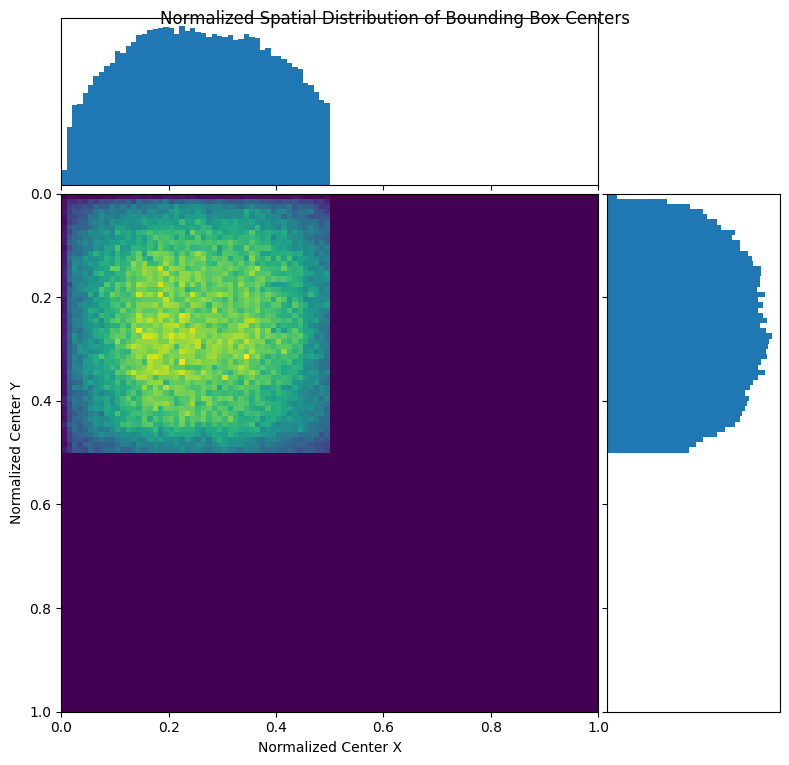

In [ ]:
# --- 1. 작은 DataFrame(images_ddf)을 Pandas로 변환 ---
print("작은 images_ddf를 메모리로 로드 중...")
# 병합 및 계산에 필요한 컬럼만 선택합니다.
images_pdf = images_ddf[['id', 'width', 'height']].rename(columns={'id': 'image_id'}).compute()
print("로드 완료.")

# --- 2. map_partitions를 이용한 병합 및 계산 ---
print("map_partitions으로 병합 및 정규화 계산 계획 수립 중...")
# 병합에 필요한 annotations 컬럼만 선택
annotations_to_merge = annotations_ddf[['image_id', 'center_x', 'center_y', 'category_id']]

def merge_and_normalize(partition_df, images_lookup_df):
    """한 파티션에 대해 병합과 정규화 계산을 모두 수행하는 함수"""
    merged_partition = pd.merge(partition_df, images_lookup_df, on='image_id')
    merged_partition['norm_center_x'] = merged_partition['center_x'] / merged_partition['width']
    merged_partition['norm_center_y'] = merged_partition['center_y'] / merged_partition['height']
    return merged_partition

# Dask에게 결과물의 구조(meta)를 알려주기
meta_df = pd.DataFrame({
    'image_id': pd.Series(dtype='int32'),
    'center_x': pd.Series(dtype='float32'),
    'center_y': pd.Series(dtype='float32'),
    'category_id': pd.Series(dtype='int64'), # category_id 타입에 맞게 조정
    'width': pd.Series(dtype='int16'),
    'height': pd.Series(dtype='int16'),
    'norm_center_x': pd.Series(dtype='float64'),
    'norm_center_y': pd.Series(dtype='float64'),
})

dask_merged = annotations_to_merge.map_partitions(
    merge_and_normalize,
    images_lookup_df=images_pdf,
    meta=meta_df
)

# --- 3. 2D 히스토그램 계산 및 시각화 (이전과 동일) ---
print("시각화용 데이터 계산 중 (2D 히스토그램)...")
gridsize = 100
bins = [gridsize, gridsize]
range_ = [[0, 1], [0, 1]]

H, xedges, yedges = da.histogram2d(
    dask_merged['norm_center_x'].values,
    dask_merged['norm_center_y'].values,
    bins=bins,
    range=range_
)

computed_H, computed_xedges, computed_yedges = dask.compute(H, xedges, yedges)
print("계산 완료.")

# --- 3. 계산된 결과를 Matplotlib으로 직접 시각화 ---
print("Matplotlib으로 시각화 생성 중...")
# jointplot과 유사한 레이아웃을 직접 만듭니다.
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# 메인 2D 히스토그램 (hexbin 대신 pcolormesh 사용)
im = ax_main.pcolormesh(computed_xedges, computed_yedges, computed_H.T, cmap='viridis')
ax_main.set_xlabel('Normalized Center X')
ax_main.set_ylabel('Normalized Center Y')

# 상단 1D 히스토그램
x_counts = computed_H.sum(axis=1)
ax_top.bar(computed_xedges[:-1], x_counts, width=np.diff(computed_xedges), align='edge')
plt.setp(ax_top.get_xticklabels(), visible=False)
ax_top.set_yticks([])

# 오른쪽 1D 히스토그램
y_counts = computed_H.sum(axis=0)
ax_right.barh(computed_yedges[:-1], y_counts, height=np.diff(computed_yedges), align='edge')
plt.setp(ax_right.get_yticklabels(), visible=False)
ax_right.set_xticks([])

# 전체 제목 및 레이아웃 조정
fig.suptitle('Normalized Spatial Distribution of Bounding Box Centers', y=0.95)
ax_main.invert_yaxis() # y축 뒤집기
gs.tight_layout(fig)
gs.update(wspace=0.05, hspace=0.05)

plt.show()